# General imports

In [1]:
import json
import os
import re

from sqlite3 import connect
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import seaborn as sns

# Matplotlib configuration:

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

# Pandas configuration:

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('styler.latex.hrules', True)
pd.set_option('styler.format.precision', 2)

# Seaborn configuration:

In [4]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', palette='colorblind', rc=custom_params)

# Database connection

In [5]:
conn = connect('../crawl_jsripper_data/function_signatures-short.db')

# General statistics

Number of crawl website domains:

In [6]:
domain_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT page_domain) FROM data
    ''',
    conn,
    ).iloc[0, 0]
domain_count

6702

Count of function signatures:

In [7]:
pd.read_sql_query(
    '''
    SELECT COUNT(function_sig) FROM data
    ''',
    conn,
    ).iloc[0, 0]

44717696

Count of unique function signatures:

In [8]:
pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT function_sig) FROM data
    ''',
    conn,
    ).iloc[0, 0]

5783725

Count of scripts (including duplicates):

In [42]:
script_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT resource_url) FROM data
    ''',
    conn,
    ).iloc[0, 0]
script_count

47052

Count of unique scripts (based on actual, exact content):

In [10]:
unique_script_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT resource_sha256) FROM data
    ''',
    conn,
    ).iloc[0, 0]
unique_script_count

41944

Count of unique scripts blocked by filter lists:

In [11]:
unique_tracking_script_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT resource_sha256) FROM data
    WHERE resource_in_filter_lists = 1
    ''',
    conn,
    ).iloc[0, 0]
unique_tracking_script_count

4305

Count of unique functions manually marked as tracking:

In [13]:
unique_tracking_function_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT function_sig) FROM data
    WHERE origin_script <> '{}'
    ''',
    conn,
    ).iloc[0, 0]
unique_tracking_function_count

84

Counts of unique scripts per domain:

In [ ]:
script_count_per_domain = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT resource_sha256) FROM data
    GROUP BY page_domain
    ''',
    conn,
)

In [58]:
tracking_script_count_per_domain = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT resource_sha256) FROM data
    WHERE resource_in_filter_lists = 1
    GROUP BY page_domain
    ''',
    conn,
    )

In [62]:
script_count_per_domain_both = pd.concat([
    script_count_per_domain.rename(columns={'COUNT(DISTINCT resource_sha256)': 'All scripts'}),
    tracking_script_count_per_domain.rename(columns={'COUNT(DISTINCT resource_sha256)': 'Tracking scripts'}),
], axis=1)

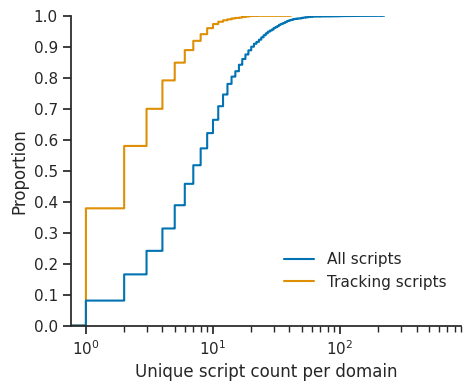

In [65]:
grid = sns.displot(
    data=script_count_per_domain_both,
    kind='ecdf',
    height=3.8,
    aspect=1.3,
)
grid.set(
    xlabel='Unique script count per domain',
    xscale='log',
    )
grid.ax.yaxis.set_major_locator(MultipleLocator(0.1))
grid.ax.set_xticks(
    [x for x in grid.ax.get_xticks(minor=True) if x >= 1 and x < 10e2],
    minor=True,
    );
sns.move_legend(grid, 'lower right', bbox_to_anchor=(0.7, 0.18))
plt.gcf().savefig('../paper-jsripper/script_count_per_domain.pdf', bbox_inches='tight')

In [18]:
unique_script_byte_sizes = pd.read_sql_query(
    '''
    SELECT resource_byte_size FROM data
    GROUP BY resource_sha256
    ''',
    conn,
)

In [50]:
unique_tracking_script_byte_sizes = pd.read_sql_query(
    '''
    SELECT resource_byte_size FROM data
    WHERE resource_in_filter_lists = 1
    GROUP BY resource_sha256
    ''',
    conn,
)

In [51]:
unique_script_byte_sizes_both = pd.concat([
    unique_script_byte_sizes.rename(columns={'resource_byte_size': 'All scripts'}),
    unique_tracking_script_byte_sizes.rename(columns={'resource_byte_size': 'Tracking scripts'}),
], axis=1)

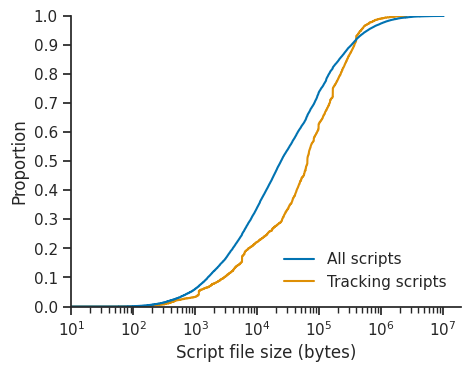

In [57]:
grid = sns.displot(
    data=unique_script_byte_sizes_both,
    kind='ecdf',
    height=3.8,
    aspect=1.3,
)
grid.set(
    xlabel='Script file size (bytes)',
    xscale='log',
    )
grid.ax.yaxis.set_major_locator(MultipleLocator(0.1))
sns.move_legend(grid, 'lower right', bbox_to_anchor=(0.7, 0.18))
plt.gcf().savefig('../paper-jsripper/unique_script_byte_sizes.pdf', bbox_inches='tight')

In [20]:
function_count_per_script = pd.read_sql_query(
    '''
    SELECT COUNT(function_sig) FROM data
    GROUP BY resource_sha256
    ''',
    conn,
)

In [22]:
function_count_per_tracking_script = pd.read_sql_query(
    '''
    SELECT COUNT(function_sig) FROM data
    WHERE resource_in_filter_lists = 1
    GROUP BY resource_sha256
    ''',
    conn,
)

In [24]:
function_count_per_scripts = pd.concat([
    function_count_per_script.rename(columns={'COUNT(function_sig)': 'All scripts'}),
    function_count_per_tracking_script.rename(columns={'COUNT(function_sig)': 'Tracking scripts'}),
], axis=1)

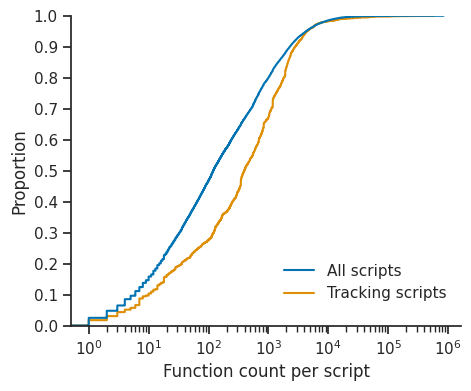

In [25]:
grid = sns.displot(
    data=function_count_per_scripts,
    kind='ecdf',
    height=3.8,
    aspect=1.3,
)
grid.set(
    xlabel='Function count per script',
    xscale='log',
    )
grid.ax.yaxis.set_major_locator(MultipleLocator(0.1))
grid.ax.set_xticks(
    [x for x in grid.ax.get_xticks(minor=True) if x >= 1 and x < 10e5],
    minor=True,
    );
sns.move_legend(grid, 'lower right', bbox_to_anchor=(0.7, 0.15))
plt.gcf().savefig('../paper-jsripper/function_count_per_scripts.pdf', bbox_inches='tight')

In [26]:
unique_function_byte_size = pd.read_sql_query(
    '''
    SELECT function_byte_end - function_byte_start FROM data
    GROUP BY function_sig
    ''',
    conn,
)

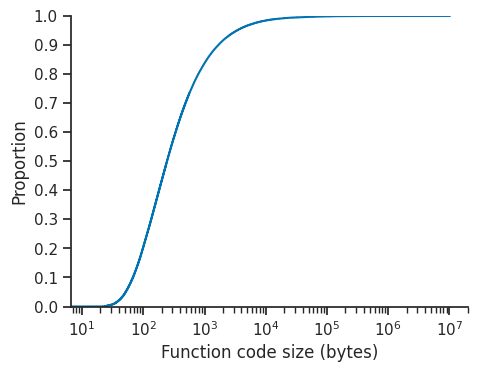

In [27]:
grid = sns.displot(
    data=unique_function_byte_size,
    kind='ecdf',
    legend=False,
    height=3.8,
    aspect=1.3,
)
grid.set(
    xlabel='Function code size (bytes)',
    xscale='log',
    )
grid.ax.yaxis.set_major_locator(MultipleLocator(0.1))
plt.gcf().savefig('../paper-jsripper/unique_function_byte_size.pdf', bbox_inches='tight')

# Bundled tracking functions

In [44]:
unblocked_scripts_having_known_tracking_functions = pd.read_sql_query(
    '''
    SELECT * FROM data
    WHERE origin_script <> '{}'
        AND resource_in_filter_lists != 1
    GROUP BY resource_sha256;
    ''',
    conn,
)
unblocked_scripts_having_known_tracking_functions

page_domain  \
0                    pcloud.com   
1                       adn.com   
2                mgmresorts.com   
3               homeadvisor.com   
4                  about.google   
5                      vxxx.com   
6                 amazonaws.com   
7                 ihsmarkit.com   
8                  muckrack.com   
9                 bloomberg.com   
10                      ncr.com   
11                    jcrew.com   
12                    abc13.com   
13                       sky.it   
14                      news.am   
15                  meethue.com   
16                     asos.com   
17                  nine.com.au   
18                musescore.com   
19                   allianz.de   
20                    clien.net   
21                tokopedia.com   
22                microchip.com   
23                  gartner.com   
24                      aip.org   
25               userreport.com   
26                     note.com   
27             superawesome.com   
28                 leetcode.com   
29               chaturbate.com   
30             collegeboard.org   
31                    tapad.com   
32                      att.com   
33                  directv.com   
34               carrentals.com   
35             familysearch.org   
36                     samba.tv   
37                 michaels.com   
38           wanfangdata.com.cn   
39                      inc.com   
40                    zoomit.ir   
41                   spiegel.de   
42           credit-agricole.fr   
43      vestiairecollective.com   
44                   truist.com   
45         coca-colacompany.com   
46                 capterra.com   
47                    simpli.fi   
48             choicehotels.com   
49                     colt.net   
50            irishexaminer.com   
51                trilltrill.jp   
52                   laposte.fr   
53                  workday.com   
54                helpguide.org   
55                 illinois.gov   
56         cancerresearchuk.org   
57                     poste.it   
58                      dxc.com   
59                   moodys.com   
60                   hclips.com   
61              ahajournals.org   
62                    today.com   
63                   zazzle.com   
64                 vecteezy.com   
65                carlsberg.com   
66                  thestar.com   
67                   marvel.com   
68                  politico.eu   
69                     avon.com   
70                     cnet.com   
71          channelnewsasia.com   
72                    tapad.com   
73            wyndhamhotels.com   
74                   sonobi.com   
75               solarwinds.com   
76                   pfizer.com   
77                 qualcomm.com   
78             civicscience.com   
79                      cnn.com   
80         delltechnologies.com   
81                     eset.com   
82             bigfishgames.com   
83                      ada.org   
84                    shein.com   
85                  adswizz.com   
86                    chron.com   
87                    sears.com   
88                 lanhuapp.com   
89               transunion.com   
90           barnesandnoble.com   
91              playstation.com   
92                    jivox.com   
93                     xero.com   
94                  abtasty.com   
95                  eldiario.es   
96              theadvocate.com   
97              sleepnumber.com   
98                    zmags.com   
99                skysports.com   
100              jwplatform.com   
101                  amtrak.com   
102                   veeam.com   
103                kaskus.co.id   
104             adelaide.edu.au   
105           microstrategy.com   
106               chronicle.com   
107                  laposte.fr   
108                trellian.com   
109          credit-agricole.fr   
110                  eyeota.net   
111               refinitiv.com   
112                    ayco.com   
113                    cnet.co

Scripts (likely bundles) having at least a function manually marked as tracking and coming from a tracking library:

In [45]:
sample_bundles = unknown_scripts_having_known_tracking_functions[['resource_url', 'origin_script']] \
    .sample(frac=1, random_state=42) \
    .reset_index(drop=True) \
    .truncate(after=10)
sample_bundles['resource_url'] = sample_bundles['resource_url'] \
    .transform(lambda s: s.replace('_', '\\_'))
sample_bundles['origin_script'] = sample_bundles['origin_script'] \
    .transform(lambda s: json.loads(s))
sample_bundles = sample_bundles \
    .rename(columns={'resource_url': 'Scripts containing tracking functions', 'origin_script': 'Known tracking scripts'})
sample_bundles.style.hide(axis='index').to_latex(
    '../paper-jsripper/sample_bundles.tex',
    position='t',
    environment='sidewaystable',
    column_format='ll',
    label='tab:sample_bundles',
    caption='Examples of scripts bundling tracking functions, these scripts are not part of filter lists',
)
sample_bundles[['Scripts containing tracking functions']] \
    .transform(lambda s: s.replace('_', '\_')).style.hide(axis='index').to_latex(
    '../paper-jsripper/sample_bundles_bundle_only.tex',
    position='t',
    environment='table*',
    column_format='ll',
    label='tab:sample_bundles_bundle_only',
    caption='Examples of scripts containing tracking functions, these scripts are not part of filter lists',
)
sample_bundles

Scripts containing tracking functions  \
0               https://cdne-static.cdn1122.com/app/1/js/headerScripts-bee09d045e.js   
1        https://at.adtech.redventures.io/lib/dist/prod/bidbarrel-gamespot-rv.min.js   
2   https://assets.adobedtm.com/10cb5d082fb7/7363b27fd56b/launch-644b0be21518.min.js   
3   https://assets.adobedtm.com/99ab9d5e7462/49f8eb1d5b8b/launch-4524888c9125.min.js   
4       https://assets.adobedtm.com/launch-ENed26431217ec4f129cc3055077309c86.min.js   
5                                               https://js.hs-banner.com/20180325.js   
6   https://assets.adobedtm.com/6809d1ba6f0c/c4bef609fe0d/launch-b1aeef4798eb.min.js   
7                                                   https://u566.chron.com/script.js   
8                                                https://js.hs-banner.com/7228775.js   
9                                                https://js.hs-banner.com/7401505.js   
10      https://www.instacart.com/assets/594.webpack\_bundle-6131304afbf731b42684.js   

                                                                         Known tracking scripts  
0         {'client-side-storage': ['https://js-sec.indexww.com/ht/p/185104-83017197662295.js']}  
1                           {'client-side-storage': ['https://hb.20m.es/prebid/7.14.0-ats.js']}  
2        {'client-side-storage': ['https://s.abcnews.com/assets/dtci/js/abcnews_visitorId.js']}  
3        {'client-side-storage': ['https://s.abcnews.com/assets/dtci/js/abcnews_visitorId.js']}  
4        {'client-side-storage': ['https://s.abcnews.com/assets/dtci/js/abcnews_visitorId.js']}  
5   {'client-side-storage': ['https://js.hs-analytics.net/analytics/1664897100000/6743804.js']}  
6        {'client-side-storage': ['https://s.abcnews.com/assets/dtci/js/abcnews_visitorId.js']}  
7                                 {'client-side-storage': ['https://cdn.blueconic.net/akc.js']}  
8   {'client-side-storage': ['https://js.hs-analytics.net/analytics/1664897100000/6743804.js']}  
9   {'client-side-storage': ['https://js.hs-analytics.net/analytics/1664897100000/6743804.js']}  
10      {'client-side-storage': ['https://www.datadoghq-browser-agent.com/datadog-logs-v4.js']}

Tracking scripts most often bundled:

In [46]:
tracking_scripts_most_often_bundled = unblocked_scripts_having_known_tracking_functions['origin_script'] \
    .apply(lambda s: json.loads(s)) \
    .value_counts() \
    .to_frame() \
    .reset_index() \
    .rename(columns={'index': 'Tracking script', 'origin_script': 'Bundle count'})
tracking_scripts_most_often_bundled.style.hide(axis='index').to_latex(
    '../paper-jsripper/tracking_scripts_most_often_bundled.tex',
    position='t',
    environment='table*',
    column_format='lr',
    label='tab:tracking_scripts_most_often_bundled',
    caption='Tracking scripts whose tracking functions are most often bundled',
    )
tracking_scripts_most_often_bundled.truncate(after=5).style.hide(axis='index').to_latex(
    '../paper-jsripper/tracking_scripts_most_often_bundled_top_5.tex',
    position='t',
    environment='table*',
    column_format='lr',
    label='tab:tracking_scripts_most_often_bundled_top_5',
    caption='Tracking scripts whose tracking functions are most often bundled (truncated to top~5)',
)
tracking_scripts_most_often_bundled

Tracking script  \
0                                                                                      {'client-side-storage': ['https://s.abcnews.com/assets/dtci/js/abcnews_visitorId.js']}   
1                                                                                 {'client-side-storage': ['https://js.hs-analytics.net/analytics/1664897100000/6743804.js']}   
2                  {'client-side-storage': ['https://assets.adobedtm.com/1b53c5850d5cfd2a9d4095a589f75aff7bf553e1/satelliteLib-56f64459740ad931a560f979e3c72fbe8636b7fe.js']}   
3                                                                                                         {'client-side-storage': ['https://hb.20m.es/prebid/7.14.0-ats.js']}   
4                                                    {'client-side-storage': ['https://lightning.adultswim.com/launch/7be62238e4c3/22d196a3e151/launch-2fa6614adbd9.min.js']}   
5                                                                                                  {'browser-fingerprinting': ['https://www.clickcease.com/monitor/stat.js']}   
6                                                                                                       {'client-side-storage': ['https://analytics.ovh.com/ovh/ovh_abt.js']}   
7                                                                                     {'client-side-storage': ['https://www.datadoghq-browser-agent.com/datadog-logs-v4.js']}   
8                                                                {'browser-fingerprinting': ['https://www.cengage.uk/webfiles/1660990212508/cengage/common/js/analytics.js']}   
9                                                                                                               {'client-side-storage': ['https://cdn.blueconic.net/akc.js']}   
10                                                                                 {'client-side-storage': ['https://ensighten.bhphoto.com/bhfoto/prodPrivacy/Bootstrap.js']}   
11                                                                                      {'client-side-storage': ['https://js-sec.indexww.com/ht/p/185104-83017197662295.js']}   
12                                               {'client-side-storage': ['https://assets.adobedtm.com/extensions/EP171e731c9ba34f1c950c36d26e3efd61/AppMeasurement.min.js']}   
13                                                                                          {'client-side-storage': ['https://collector-16829.us.tvsquared.com/tv2track.js']}   
14                                                                                              {'client-side-storage': ['https://cdn.treasuredata.com/sdk/1.9.2/td.min.js']}   
15                                                                                          {'client-side-storage': ['https://securepubads.g.doubleclick.net/tag/js/gpt.js']}   
16                                                                                                 {'client-side-storage': ['https://www.google-analytics.com/analytics.js']}   
17                                                                                          {'browser-fingerprinting': ['https://assets.pixlee.com/assets/pixlee_events.js']}   
18                                                                                                      {'browser-fingerprinting': ['https://www.kiva.org/r3pNVz1F/init.js']}   
19  {'client-side-storage': ['https://cdn.optimizely.com/public/27075387/15141160728/14646_df32850f6a47090364af7dc57d1ea22a4d4c01608f7f73c1fe2dd50f2e96db7c_edge_helper.js']}   
20                                                                        {'client-side-storage': ['https://all.accor.com/ruxitagentjs_ICA27Vfghjqrux_10249220905100923.js']}   
21                     {'client-side-storage': ['https://assets.adobedtm.com/extensions/EP7b1fa4581fb94dd0961a981af9997765/AppMeasurement_Module_AudienceManagement.min.js']}   
22                                                                 {'browser-fingerprin

Percentage of unique scripts having bundled tracking script out of unique scripts unknown to filter lists:

In [47]:
100 * unblocked_scripts_having_known_tracking_functions.shape[0] / (unique_script_count-unique_tracking_script_count)

2.186561810887643

In [48]:
domain_having_tracking_bundle_count = pd.read_sql_query(
    '''
    SELECT COUNT(DISTINCT page_domain) FROM data
    WHERE origin_script <> '{}'
        AND resource_in_filter_lists != 1
    ''',
    conn,
    ).iloc[0, 0]
domain_having_tracking_bundle_count

922

Percentage of domains having at least one script (unknown to filter list) having a tracking function:

In [37]:
100 * domain_having_tracking_bundle_count / domain_count

13.757087436586094

# Case studies

In [38]:
marked_unblocked_scripts = pd.read_sql_query(
    '''
    SELECT page_domain, resource_url, origin_script FROM data
    WHERE origin_script <> '{}'
        AND resource_in_filter_lists != 1
    GROUP BY resource_url;
    ''',
    conn,
)

In [39]:
marked_unblocked_scripts.to_csv('marked_unblocked_scripts.tsv', sep='\t')

In [40]:
marked_unblocked_scripts

page_domain  \
0               statestreet.com   
1                      viki.com   
2                   videohub.tv   
3             sberbank-tele.com   
4                 amazonaws.com   
5                oregonlive.com   
6               mercurynews.com   
7                   latimes.com   
8      sandiegouniontribune.com   
9                     goo.ne.jp   
10            bankofthewest.com   
11                overstock.com   
12                     acfun.cn   
13                      syf.com   
14                  uni-kiel.de   
15                   wbs-law.de   
16                    zoomit.ir   
17                     shimo.im   
18                 faphouse.com   
19                 calendly.com   
20                    petco.com   
21                      k12.com   
22                 nintendo.com   
23                   scania.com   
24                   subway.com   
25             familysearch.org   
26                    adage.com   
27                 autonews.com   
28                     fnac.com   
29                       abc.es   
30                cadenaser.com   
31                       as.com   
32                penguin.co.uk   
33            barclaycardus.com   
34                    lowes.com   
35                      faz.net   
36          harley-davidson.com   
37                   marvel.com   
38                       sbb.ch   
39                 redcross.org   
40                      asm.org   
41          southernglazers.com   
42         coca-colacompany.com   
43               transunion.com   
44                      pnc.com   
45                 discover.com   
46                      bms.com   
47                   dupont.com   
48                worldbank.org   
49                 comenity.net   
50                   pfizer.com   
51                      mlb.com   
52                       sky.it   
53               scotiabank.com   
54          channelnewsasia.com   
55                 medscape.com   
56                    webmd.com   
57              medicinenet.com   
58                  verizon.com   
59                       wm.com   
60                     cars.com   
61                     sony.com   
62                    casio.com   
63          comcastbusiness.net   
64                  comcast.net   
65              sleepnumber.com   
66                sharefile.com   
67                    podio.com   
68                   citrix.com   
69              playstation.com   
70            microstrategy.com   
71                eurosport.com   
72                  cargill.com   
73                   lenovo.com   
74           heraldscotland.com   
75                   scopus.com   
76                 mendeley.com   
77                      wgu.edu   
78                   kroger.com   
79                christies.com   
80                  shopbop.com   
81                    optum.com   
82                  unsw.edu.au   
83               shutterfly.com   
84         networksolutions.com   
85                   truist.com   
86                      dow.com   
87                    wiley.com   
88                  dummies.com   
89             econsultancy.com   
90                  keybank.com   
91                  geforce.com   
92              canadiantire.ca   
93                     1drv.com   
94                   moodys.com   
95                   netapp.com   
96                      box.com   
97                   marcus.com   
98                 songkick.com   
99                   fitbit.com   
100                   tapad.com   
101                 realtor.com   
102             adelaide.edu.au   
103               microchip.com   
104                       hs.fi   
105                       is.fi   
106                  costco.com   
107                bmwgroup.com   
108                     dnb.com   
109             telegraph.co.uk   
110           wyndhamhotels.com   
111                 samsung.com   
112                  edweek.org   
113                onetrust.co